In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
#from matplotlib.colors import ListedColormap

In [52]:
#parameters
#alpha_param = 0.5 #prob
#beta_param = 0.5  #prob
r_search = 3.5  # r_search > r_wait'
r_wait = 0.5

In [53]:
#states and actions
states = ['high', 'low']
actions = { 'high': ['search', 'wait'],
            'low': ['search', 'wait', 'recharge']}

In [54]:
#environment
def environment_steps(state, action, alpha_param, beta_param):
    if state == 'high':
        if action == 'search':
            if np.random.rand() < alpha_param:
                next_state = 'high'
            else:
                next_state = 'low'
            reward = r_search
        elif action == 'wait':
            next_state = 'high'
            reward = r_wait
    elif state == 'low':
        if action == 'search':
            if np.random.rand() < beta_param:
                next_state = 'low'
                reward = r_search
            else:
                next_state = 'high'
                reward = -3
        elif action == 'wait':
            next_state = 'low'
            reward = r_wait
        elif action == 'recharge':
            next_state = 'high'
            reward = 0
    return next_state, reward

In [55]:
#training parameters
alpha_lr = 0.1 
gamma = 0.9 
epochs = 100
steps_per_epoch = 1000

epsilon = 0.1 #e-greedy

rewards_per_epoch = []

In [56]:
#td algorithm
def td_learning(alpha_lr, gamma, epochs, steps_per_epoch, epsilon, alpha_param, beta_param):
    #Initializating value function V(s)
    V = {state: 0.0 for state in states}
    #Policy pi(s) (Initial policy random)
    policy = {'high': {'search': 1/2, 'wait': 1/2},
              'low': {'search': 1/3, 'wait': 1/3, 'recharge': 1/3}}
    
    rewards_list = []

    for epoch in range(epochs):
        state = np.random.choice(states)
        total_reward = 0

        for step in range(steps_per_epoch):
            # selection action by e-greedy
            #epsilon = 0.1 
            if np.random.rand() < epsilon:
                # Exploration: select action randomly
                action = np.random.choice(actions[state])
            else:
                # Explotation: use policy learned
                action_probs = policy[state]
                action = np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))
            
            # execute action (environment)
            next_state, reward = environment_steps(state, action, alpha_param, beta_param)
            total_reward += reward
            
            # update td(0): V(s) ← V(s) + α[r + γV(s') - V(s)]
            td_target = reward + gamma * V[next_state]
            td_error = td_target - V[state]
            V[state] += alpha_lr * td_error
            
            # improve policy based in V(s)
            update_policy(policy, V, state, epsilon, alpha_param, beta_param)
            
            # move to next state
            state = next_state
        
        # store total_reward
        rewards_list.append(total_reward)
    
    return V, policy, rewards_list

In [57]:
#update policy values
def update_policy(policy, V, state, epsilon, alpha_param, beta_param):
    #cases
    if state == 'high':
        # 'search' and 'wait' results in different states
        valid_actions = ['search', 'wait']
        value_search = r_search + gamma * (alpha_param * V['high'] + (1-alpha_param) * V['low'])
        value_wait = r_wait + gamma * V['high']
        
        #best action
        values = [value_search, value_wait]
        best_action = valid_actions[np.argmax(values)]

        # Update policy with e-greedy
        for action in valid_actions:
            if action == best_action:
                policy[state][action] = 1 - epsilon + epsilon / len(valid_actions)
            else:
                policy[state][action] = epsilon / len(valid_actions)
            
    else:  # state == 'low'
        # 'low': actions result in different states
        valid_actions = ['search', 'wait', 'recharge']
        value_search = beta_param * (r_search + gamma * V['low']) + (1 - beta_param) * (-3 + gamma * V['high'])
        value_wait = r_wait + gamma * V['low']
        value_recharge = 0 + gamma * V['high']
        
        #best action
        values = [value_search, value_wait, value_recharge]
        best_action = valid_actions[np.argmax(values)]

        # Update policy with e-greedy
        for action in valid_actions:
            if action == best_action:
                policy[state][action] = 1 - epsilon + epsilon / len(valid_actions)
            else:
                policy[state][action] = epsilon / len(valid_actions)

In [58]:
def test_parameter_combinations():
    #test differents values
    alpha_values = np.arange(0.1, 1, 0.1)  #alpha: 0.1:0.9
    beta_values = np.arange(0.1, 1, 0.1)   #beta: 0.1:0.9
    r_search_values = np.arange(1, 6)  # r_search: 1:5
    r_wait_values = np.arange(0, 5)    # r_wait: 0:4
    
    best_mean_reward = -float('inf')
    best_alpha = None
    best_beta = None
    best_r_search = None
    best_r_wait = None
    results = []
    
    # Generar todas las combinaciones válidas (r_search > r_wait)
    valid_combinations = []
    for r_s, r_w in product(r_search_values, r_wait_values):
        if r_s > r_w:
            valid_combinations.append((r_s, r_w))
    
    for alpha_val, beta_val, (r_s_val, r_w_val) in product(alpha_values, beta_values, valid_combinations):
        print(f"Testing alpha={alpha_val:.1f}, beta={beta_val:.1f}, r_search={r_s_val}, r_wait={r_w_val}")
        
        # Establecer los valores globales de r_search y r_wait
        global r_search, r_wait
        r_search = r_s_val
        r_wait = r_w_val
        
        # Ejecutar el algoritmo TD
        V, policy, rewards_hist = td_learning(
            alpha_lr=alpha_lr, 
            gamma=gamma, 
            epochs=epochs, 
            steps_per_epoch=steps_per_epoch, 
            epsilon=epsilon,
            alpha_param=alpha_val,
            beta_param=beta_val
        )
        
        mean_reward = np.mean(rewards_hist)
        results.append((alpha_val, beta_val, r_s_val, r_w_val, mean_reward))
        
        print(f" Average Reward: {mean_reward:.2f}")
        
        # Actualizar mejor combinación
        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            best_alpha = alpha_val
            best_beta = beta_val
            best_r_search = r_s_val
            best_r_wait = r_w_val
    
    return best_alpha, best_beta, best_r_search, best_r_wait, best_mean_reward, results

In [59]:
def save_results(rewards_history):
    # Save rewards in *txt
    with open('rewards_best_result.txt', 'w') as f:
        for reward in rewards_history:
            f.write(f"{reward}\n")

In [60]:
# #plot with best results
# def plot_alpha_beta_results(results):
#     alpha_vals = sorted(set(alpha for alpha, beta, reward in results))
#     beta_vals = sorted(set(beta for alpha, beta, reward in results))
    
#     reward_matrix = np.zeros((len(alpha_vals), len(beta_vals)))
    
#     for alpha, beta, reward in results:
#         i = np.where(alpha_vals == alpha)[0][0]
#         j = np.where(beta_vals == beta)[0][0]
#         reward_matrix[i, j] = reward
    
#     # heatmap
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(reward_matrix, annot=True, fmt='.0f', cmap='viridis',
#                 xticklabels=[f'{b:.1f}' for b in beta_vals],
#                 yticklabels=[f'{a:.1f}' for a in alpha_vals])
#     plt.title('Average Reward by combination of \alpha and \beta')
#     plt.xlabel('Beta')
#     plt.ylabel('Alpha')
#     plt.tight_layout()
#     plt.show()

In [ ]:
def main():
    print("Testing different combinations of alpha, beta, r_search and r_wait")
    best_alpha, best_beta, best_r_search, best_r_wait, best_mean_reward, results = test_parameter_combinations()
    
    print(f"\nBest combination: alpha={best_alpha:.1f}, beta={best_beta:.1f}, r_search={best_r_search}, r_wait={best_r_wait}")
    print(f"Best average reward: {best_mean_reward:.2f}")
    
    # Run with the best parameters to obtain the Optimal Policy
    # Ejecutar con los mejores parámetros para obtener la política óptima
    print(f"\nRunning with best parameters (alpha={best_alpha:.1f}, beta={best_beta:.1f}, r_search={best_r_search}, r_wait={best_r_wait})")
    
    # Set best global values
    # Establecer los mejores valores globales
    global r_search, r_wait
    r_search = best_r_search
    r_wait = best_r_wait
    
    V, policy, rewards_hist = td_learning(alpha_lr=alpha_lr, 
                                            gamma=gamma, 
                                            epochs=epochs, 
                                            steps_per_epoch=steps_per_epoch, 
                                            epsilon=epsilon,
                                            alpha_param=best_alpha,
                                            beta_param=best_beta)
    
    # Results
    print(f"\nLearned V(s): {V}")
    print(f"\nOptimal policy:")
    for state in states:
        print(f"  {state}: {policy[state]}")
    
    print(f"\nAverage reward: {np.mean(rewards_hist):.2f}")



In [62]:
main()

Testing different combinations of alpha, beta, r_search and r_wait
Testing alpha=0.1, beta=0.1, r_search=1, r_wait=0
 Average Reward: 405.00
Testing alpha=0.1, beta=0.1, r_search=2, r_wait=0
 Average Reward: 889.00
Testing alpha=0.1, beta=0.1, r_search=2, r_wait=1
 Average Reward: 971.06
Testing alpha=0.1, beta=0.1, r_search=3, r_wait=0
 Average Reward: 1376.34
Testing alpha=0.1, beta=0.1, r_search=3, r_wait=1
 Average Reward: 1454.04
Testing alpha=0.1, beta=0.1, r_search=3, r_wait=2
 Average Reward: 1887.40
Testing alpha=0.1, beta=0.1, r_search=4, r_wait=0
 Average Reward: 1862.86
Testing alpha=0.1, beta=0.1, r_search=4, r_wait=1
 Average Reward: 1936.32
Testing alpha=0.1, beta=0.1, r_search=4, r_wait=2
 Average Reward: 1953.41
Testing alpha=0.1, beta=0.1, r_search=4, r_wait=3
 Average Reward: 2836.57
Testing alpha=0.1, beta=0.1, r_search=5, r_wait=0
 Average Reward: 2340.52
Testing alpha=0.1, beta=0.1, r_search=5, r_wait=1
 Average Reward: 2430.49
Testing alpha=0.1, beta=0.1, r_searc

Time: 41m 34s

Best combination: alpha=0.9, beta=0.9, r_search=5, r_wait=4
Best average reward: 4527.14

Running with best parameters (alpha=0.9, beta=0.9, r_search=5, r_wait=4)

In [71]:
#visualization with best results
def plot_results(rewards_history, policy):
    
    #Plot of Cumulative rewards 
    plt.figure(figsize=(12, 5))    
    plt.subplot(1, 2, 1)
    plt.plot(rewards_history, alpha=0.7)
    plt.title('Total reward per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulate reward')
    plt.grid(linestyle='--', color='gray', alpha=0.5)
    
    # Heatmap of Optimal Policy
    plt.subplot(1, 2, 2)    
    policy_matrix = np.zeros((2, 3))  # heatmap_matrix  
    # Fill policy probabilities matrix
    policy_matrix[0, 0] = policy['high']['search']  # high -> search
    policy_matrix[0, 1] = policy['high']['wait']    # high -> wait
    policy_matrix[0, 2] = 0                         # high -> recharge is 0   
    policy_matrix[1, 0] = policy['low']['search']   # low -> search
    policy_matrix[1, 1] = policy['low']['wait']     # low -> wait
    policy_matrix[1, 2] = policy['low']['recharge'] # low -> recharge
    
    # heatmap (seaborn)
    sns.heatmap(policy_matrix, annot=True, fmt='.2f', cmap='Blues', #YlOrRd
                    xticklabels=['Search', 'Wait', 'Recharge'],
                    yticklabels=['High', 'Low'])
    plt.title('Optimal Policy: action probabilities')
    plt.ylabel('State')
    plt.xlabel('Action')    
    plt.tight_layout()
    #plt.savefig('policy_heatmap.png')
    plt.show()

In [72]:
best_alpha = 0.9
best_beta = 0.9

V, policy, rewards_hist = td_learning(
                                        alpha_lr=alpha_lr, 
                                        gamma=gamma, 
                                        epochs=epochs, 
                                        steps_per_epoch=steps_per_epoch, 
                                        epsilon=epsilon,
                                        alpha_param=best_alpha,
                                        beta_param=best_beta)


V(s) learned: {'high': np.float64(46.132335538156426), 'low': np.float64(41.79538486524546)}

Optimal Policy:
  high: {'search': 0.9500000000000001, 'wait': 0.05}
  low: {'search': 0.9333333333333333, 'wait': 0.03333333333333333, 'recharge': 0.03333333333333333}

Average(Reward): 4528.92
plot


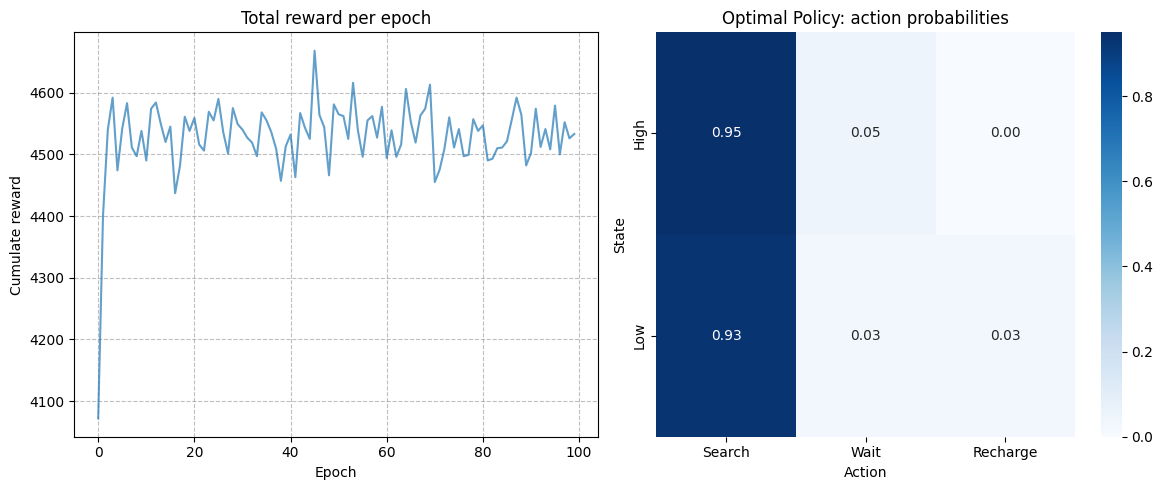

In [73]:
# Results
print(f"\nV(s) learned: {V}")
print(f"\nOptimal Policy:")
for state in states:
    print(f"  {state}: {policy[state]}")

print(f"\nAverage(Reward): {np.mean(rewards_hist):.2f}")   

# Visualization
print("plot")
plot_results(rewards_hist, policy)


In [75]:
save_results(rewards_hist)